In [ ]:
import os

os.chdir('../../../../data/RandomForest/BenchRF_bulk/')

Mounted at /content/drive
/content/drive/My Drive/APNet_12-13-2024/PASNet/MGH-MAYO-STANFORD_RF


In [ ]:
!pip install shap==0.42.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


# Input Libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score
import shap
import matplotlib.pyplot as plt

import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
import plotly

import pickle

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Load datasets

In [ ]:
#mgh = pd.read_excel('ins/MGH_TRAINING_reduced.xlsx') # use it for griding
mgh = pd.read_excel('ins/MGH_TRAINING.xlsx')
may = pd.read_excel('ins/MAYO_VALIDATION.xlsx')
std = pd.read_excel('ins/STANFORD_TEST.xlsx')

## filter / take 150 first rows (samples) """MGH""" 50 -- 50  conditions [0,1] from MGH_TRAINING_reduced.xlsx

In [ ]:
mgh.drop('SAMPLES', axis=1, inplace=True)
may.drop('SAMPLES', axis=1, inplace=True)
std.drop('SAMPLES', axis=1, inplace=True)

In [ ]:
col = mgh.drop(['Condition'], axis=1).columns

sc = StandardScaler()

for i in col:
  mgh[[i]] = sc.fit_transform(mgh[[i]])
  may[[i]] = sc.fit_transform(may[[i]])
  std[[i]] = sc.fit_transform(std[[i]])

In [ ]:
X = mgh.drop('Condition', axis=1)
y = mgh['Condition']

In [ ]:
X_test1 = may.drop('Condition', axis=1)
y_test1 = may['Condition']

In [ ]:
X_test2 = std.drop('Condition', axis=1)
y_test2 = std['Condition']

# Griding

In [ ]:
param_grid = {
	'n_estimators': [200, 250, 300, 350],
	'max_features': ['sqrt', 'log2', None],
	'max_depth': [3, 6, 9, 5, 10, 20],
	'max_leaf_nodes': [3, 6, 9],
  'n_estimators':[200, 250, 300, 350],
  'class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

## RETURN AND RUN AGAIN FROM SCRATCH WITH WHOLE SAMPLES

# Run

In [ ]:
clf = RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=6,
                       n_estimators=50, random_state=0,) ## CHANGE ALL THIS ACCORDING TO GRID OUTPUTS
# random.seed(1234)
clf.fit(X, y)

In [ ]:
# Save the model
#with open('outs/mgh-mayo_.pkl', 'wb') as file:
#    pickle.dump(clf, file)

In [ ]:
# Load the model
with open('outs/mgh-mayo_model_RF.pkl', 'rb') as file:
    clf = pickle.load(file)

In [ ]:
y_pred1 = clf.predict(X_test1)
y_pred2 = clf.predict(X_test2)

In [ ]:
fpr1, tpr1, thresholds1 = roc_curve(y_test1, y_pred1)
auc_t1 = auc(fpr1, tpr1)

fpr2, tpr2, thresholds2 = roc_curve(y_test2, y_pred2)
auc_t2 = auc(fpr2, tpr2)

In [ ]:
f1_t1 = f1_score(y_true=y_test1, y_pred=y_pred1)
f1_t2 = f1_score(y_true=y_test2, y_pred=y_pred2)

In [ ]:
print('AUC score Mayo:', round(auc_t1, 4))
print('AUC score Standford:', round(auc_t2, 4))
print('F1 score Mayo:', round(f1_t1, 4))
print('F1 score Standford:', round(f1_t2, 4))

AUC score Mayo: 0.6512
AUC score Standford: 0.7375
F1 score Mayo: 0.4746
F1 score Standford: 0.6486


## For Mayo Validation

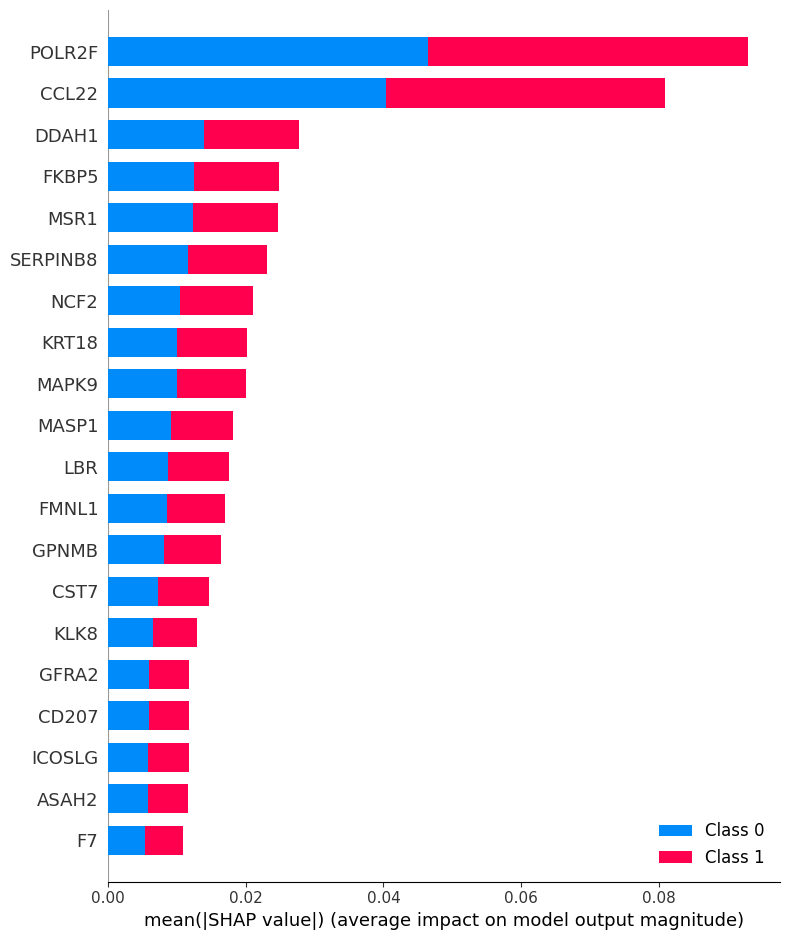

In [ ]:
# SHAP values for explainable AI
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test1)

# Load and prepare training data
tr_dt = pd.read_excel("ins/MGH_TRAINING.xlsx").drop(['Condition'], axis=1)
tr_dt = tr_dt.drop('SAMPLES', axis=1)

# Calculate average absolute SHAP values for feature importance
vals = np.abs(shap_values).mean(axis=1).mean(axis=0)  # Mean SHAP values across all samples and classes
feature_importance = pd.DataFrame(list(zip(tr_dt.columns, vals)), columns=['Feature', 'Importance'])

# Sort features by importance
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Generate and save the summary plot
fig = shap.summary_plot(shap_values, X_test1, feature_names=tr_dt.columns, max_display=20, show=False)
plt.savefig('outs/shap_values20_training.svg')
plt.savefig('outs/shap_values20_training.png', dpi=300)

# Save feature importance as csv
feature_importance.to_csv("outs/feature_importance_table_mgh_mayo.csv", index=False)

## For Stanford Testing

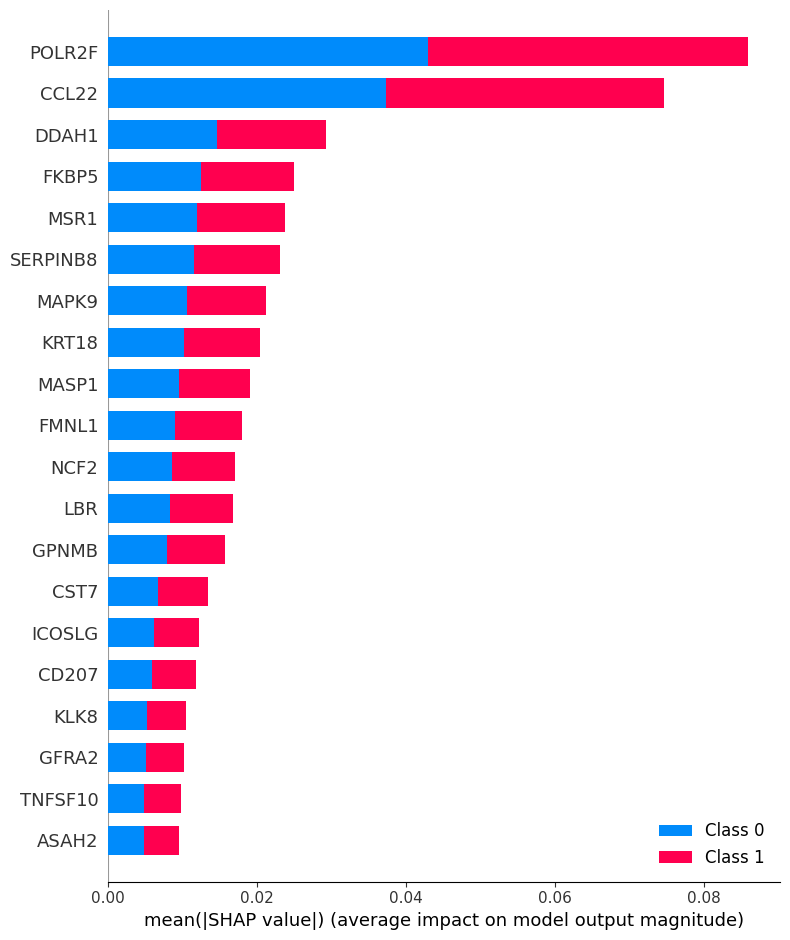

In [ ]:
# SHAP values for explainable AI
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test2)

# Load and prepare training data
tr_dt = pd.read_excel("ins/MGH_TRAINING.xlsx").drop(['Condition'], axis=1)
tr_dt = tr_dt.drop('SAMPLES', axis=1)

# Calculate average absolute SHAP values for feature importance
vals = np.abs(shap_values).mean(axis=1).mean(axis=0)  # Mean SHAP values across all samples and classes
feature_importance = pd.DataFrame(list(zip(tr_dt.columns, vals)), columns=['Feature', 'Importance'])

# Sort features by importance
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Generate and save the summary plot
fig = shap.summary_plot(shap_values, X_test2, feature_names=tr_dt.columns, max_display=20, show=False)
plt.savefig('outs/shap_values20_testing.svg')
plt.savefig('outs/shap_values20_testing.png', dpi=300)

# Save feature importance as csv
feature_importance.to_csv("outs/feature_importance_table_mgh_stanford.csv", index=False)